# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
!pip install keras-tuner

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
# Import models you're considering
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from sklearn.model_selection import GridSearchCV


/var/folders/g3/9v4gs6r57_7_bc8nsrqdz_t40000gn/T/ipykernel_5571/480258712.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Model Selection


We consider a neural network or an LSTM (those were used in the models in the literature review)



## Feature Engineering

Three feature engeneering steps were performed: Instead of using the max und min temperature, the span of temperature of that day was used. --> Tells if the weather was stable or fluctuating that day

The interaction between the average Temperature and the humidity is used -->There is a correlation between these two parameters


The pressure change is also interesting, a decreasing pressure indicates a low pressure area, an increasing pressure indicates a high pressure area


In [2]:
df = pd.read_csv(
    '../Dobersdorf/Dobersdorf_all_cut_final.csv',
    nrows=5
)

print(df)

   Tag  Monat  Jahr Produktion(kWH)         Tavg  Tmin  Tmax          Hum  \
0   16      7  2023           55,79  18,22083333  15,8  22,1  74,91666667   
1   17      7  2023           54,63  16,38333333  12,4  19,4        78,75   
2   18      7  2023           65,68  16,70416667  11,8  21,6  73,54166667   
3   19      7  2023           28,26      14,7125  12,7  17,2       85,625   
4   20      7  2023           58,93  14,91666667  10,7  19,4         76,5   

           VPD Prec  Pbin         Wspd Wmax         Wdir          Cld   Sol  \
0   0,56164731  0,8     1  4,445833333    7  219,5186547        6,125  1991   
1  0,424523113    7     1  3,929166667    6  236,8576391  6,041666667  2102   
2  0,577180231    0     1  2,941666667  5,3    253,92248  5,416666667  2578   
3  0,247361166  2,9     1  1,820833333  2,9  244,7083359  7,291666667  1121   
4  0,447117605  0,3     1        3,625  6,1  268,2167486  3,708333333  2456   

    Sun         Pres          Vis  Soil  
0   7,7  1004,179167

In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('../Dobersdorf/Dobersdorf_all_cut_final.csv', sep=",",  header=0)
print(df.columns.tolist())
print(df.dtypes)

####the floats are not recognized as floats
for col in df.columns:
    if df[col].dtype == object:
        df[col] = (
            df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')
        )
print(df.dtypes)
# Perform any feature engineering steps
# Example: df['new_feature'] = df['feature1'] + df['feature2']
df['temp_range'] = df['Tmax'] - df['Tmin']
df['temp_hum_interaction'] = df['Tavg'] * df['Hum']
##.diff() calculates the difference to the value the day before
df['pressure_change'] = df['Pres'].diff()

# Feature and target variable selection
X = df[['Tavg', 'temp_range','temp_hum_interaction','Sun','Pres','pressure_change','Vis', 'Tmin']]
y = df['Produktion(kWH)']
###values between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = np.array(y).reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

print (int(len(df))*0.7)
print (int(len(df))*0.15)
print (int(len(df)))


split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Split the dataset
##Splitting time series data random is problematic
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(X_train)
print(y_train)

###here we had to exclude missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

###here we had to exclude missing values
X_test= np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]

Since we have a handable parameter space, we decided to use a Grid Search method.


In [ ]:
!pip install scikeras
!pip install -U scikit-learn scikeras

In [4]:
def dimension_train(X, y, time_step=1):
      X1, y1 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X1.append(X[i:i+time_step,:])
        y1.append(y[i+time_step])
      return np.array(X1), np.array(y1)

time_step = 10
X,y=dimension_train(X_train,y_train, time_step)

print(len(X))
print(len(y))


722
722


In [5]:
# Implement hyperparameter tuning

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
time_step = 10
def model1(units=40,learning_rate=0.1):
  model1 = Sequential()
  model1.add(Input(shape=(time_step, 8)))
  model1.add(LSTM(units, return_sequences=True))
  model1.add(LSTM(units))
  model1.add(Dense(1))
  model1.compile(optimizer = keras.optimizers.Adam( learning_rate=learning_rate), loss='mean_squared_error')
  return model1

model = KerasRegressor(
    model=model1,
    verbose=0
)

param_grid = {
    "model__units": [50,60],
    "batch_size": [8,16],
    "epochs": [50,60],
    "model__learning_rate": [0.0001, 0.00001]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)



,estimator,KerasRegresso...se epochs=1 )
,param_grid,"{'batch_size': [8, 16], 'epochs': [50, 60], 'model__learning_rate': [0.0001, 1e-05], 'model__units': [50, 60]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function mod...t 0x14e064b80>


In [6]:
print(grid_search.best_params_)

{'batch_size': 8, 'epochs': 60, 'model__learning_rate': 0.0001, 'model__units': 50}


## Implementation

[Implement the final model(s) you've selected based on the above steps.]

Based on the Grid Search hyperparameter tuning we use a batch size of 8, 60 epochs, a learning rate of 0.0001 and 50 model units per LSTM layer.

In [ ]:


# Build the LSTM model(with hyperparameters)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 8))) 
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error') 

# Train the model
result=model.fit(X, y, epochs=60, batch_size=8,validation_split=0.15)



Epoch 1/60


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0612 - val_loss: 0.1088
Epoch 2/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394 - val_loss: 0.0906
Epoch 3/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - val_loss: 0.0765
Epoch 4/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0320 - val_loss: 0.0821
Epoch 5/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0320 - val_loss: 0.0791
Epoch 6/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 - val_loss: 0.0756
Epoch 7/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0308 - val_loss: 0.0702
Epoch 8/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 - val_loss: 0.0739
Epoch 9/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311 - val_loss: 0.0698
Epoch 10/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - val_loss: 0.0686
Epoch 11/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_loss: 0.0748
Epoch 12/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - val_loss: 0.0775


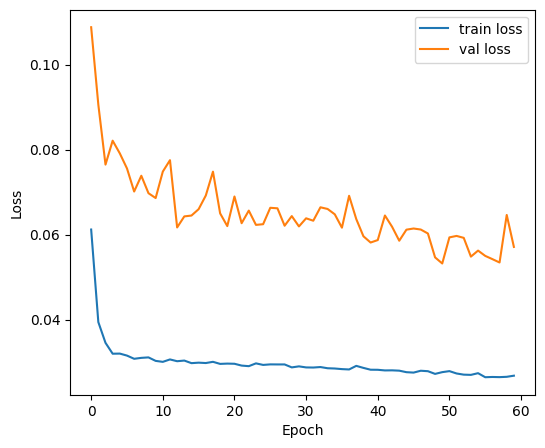

In [8]:
plt.figure(figsize=(6,5))

plt.plot(result.history["loss"], label="train loss")
plt.plot(result.history["val_loss"], label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('Dobersdorf_LSTM_loss_lr0.0001.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
print(len(X_test))
print(len(y_test))
###For the test sets
def dimension_test(X, y, time_step=1):
      X2, y2 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X2.append(X[i:i+time_step,:])
        y2.append(y[i + time_step - 1])
      return np.array(X2), np.array(y2)

time_step = 10
X_test1,y_test1=dimension_test(X_test,y_test, time_step)
print(len(X_test1))
print(len(y_test1))


183
183
173
173


## Evaluation Metrics

We use the mean absolute error for the evalution metrics since it can be directly related to an accuracy in %


In [11]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
y_pred = model.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred)
print("Mean squared error is:",mse)
mae= mean_absolute_error(y_test1, y_pred)
print("Mean absolute error is:",mae)

final=mae/np.max(y_test1)*100
print(final)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Mean squared error is: 0.01567538499078093
Mean absolute error is: 0.09667363913474543
11.714461835157932


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]

Both model perform reasonably well, but the baseline model performs even a bit better. We think that one would need a bit more data to train the larger LSTM model, with sufficient data it should be able to outperform the baseline model in principle.


In [12]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model

baseline_error= 9.59
print(f"Baseline Model error: {baseline_error} %, LSTM Model error: {final:.4} %")


Baseline Model error: 9.59 %, LSTM Model error: 11.71 %


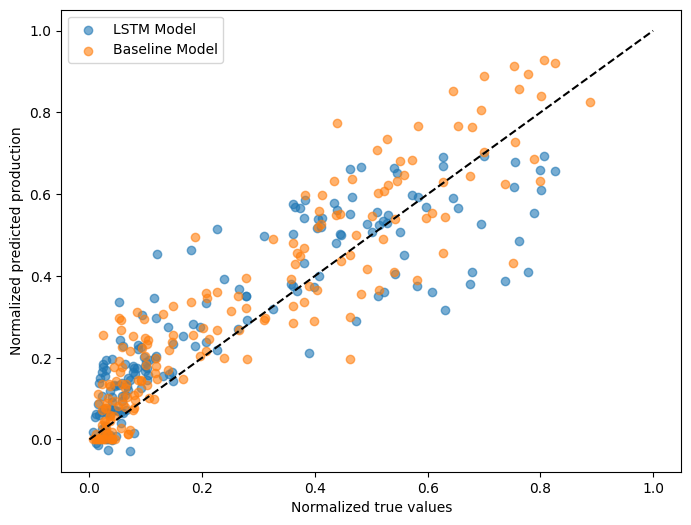

In [13]:
# Comparison between baseline and LSTM model

DB=np.load('Dobersdorf_baseline_true_vs_predicted.npy')

plt.figure(figsize=(8,6))
plt.scatter(y_test1, y_pred, label='LSTM Model', alpha=0.6)
plt.scatter(DB[0], DB[1], label='Baseline Model', alpha=0.6)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('Normalized true values')
plt.ylabel('Normalized predicted production')
plt.legend()
plt.show()